In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Import Dataset

In [2]:
from poc_data import PocDataset

poc_raw_dataset = PocDataset(num_cases=2**10)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=128)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))

print(batch.shape)
print(event.shape)
print(time_to_event.shape)
print(_latent_variable.shape)

torch.Size([128, 30, 3])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


### Data Exploration

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.]])
tensor([[27.],
        [13.],
        [15.],
        [ 5.],
        [23.]])
tensor([[0.9195],
        [0.4395],
        [0.4979],
        [0.1459],
        [0.7697]])


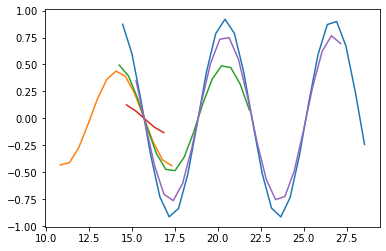

In [3]:
#Take a look at the longitudional data

plt.plot(np.array(batch[0][:int(time_to_event[0]),1]), batch[0][:int(time_to_event[0]),2])
plt.plot(np.array(batch[1][:int(time_to_event[1]),1]), batch[1][:int(time_to_event[1]),2])
plt.plot(np.array(batch[2][:int(time_to_event[2]),1]), batch[2][:int(time_to_event[2]),2])
plt.plot(np.array(batch[3][:int(time_to_event[3]),1]), batch[3][:int(time_to_event[3]),2])
plt.plot(np.array(batch[4][:int(time_to_event[4]),1]), batch[4][:int(time_to_event[4]),2])

print(event[:5])
print(time_to_event[:5])
print(_latent_variable[:5])

# 2. Hyperparameters

In [4]:
input_size = 3
output_size = input_size
hidden_size = 32
MAX_LENGTH = 30

# 3. Defining The Model

In [5]:
from dynamicDeepHit import EncoderRNN, AttnDecoderRNN

encoder = EncoderRNN(input_size, hidden_size)
decoder = AttnDecoderRNN(hidden_size, output_size, max_length=MAX_LENGTH)

In [6]:
from poc_data import PocDataset

poc_raw_dataset = PocDataset(num_cases=2**10)
data_loader = torch.utils.data.DataLoader(poc_raw_dataset,batch_size=1)
batch, event, time_to_event, _latent_variable = next(iter(data_loader))


print(batch.size())

torch.Size([1, 30, 3])


In [7]:
encoder_hidden_vector = torch.zeros(MAX_LENGTH, encoder.hidden_size)
input_length = batch.size(1)

encoder_hidden = encoder.initHidden()

for ei in range(input_length):
    encoder_input = batch[0][ei].view(1,1,-1)
    encoder_output, encoder_hidden = encoder(encoder_input, encoder_hidden)
    encoder_hidden_vector[ei] = encoder_hidden[0,0]


last_measurement_index = int(time_to_event.item())
last_measurement = batch[0][ei]

context_vector, attn_weights = decoder(last_measurement, encoder_hidden_vector)

print(context_vector.size())
print(attn_weights.size())



SyntaxError: invalid syntax (<ipython-input-7-061eaba1a754>, line 17)

# 4. Training the model

In [ ]:

from torch.nn import MSELoss
from tqdm import trange

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

NUM_EPOCHS = 100
LEARNING_RATE = 0.001

writer = SummaryWriter()

# initialize model
model.to('cuda')
 
# intialize optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
 
# initialize loss
mse_loss = MSELoss()

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for i, data in enumerate(data_loader):

    data = batch, _, _, _

    # bringing batches to GPU
    batch = batch.to('cuda')

    # zero parameter gradient
    optimizer.zero_grad()

    # forward, backward, optimize
    outputs, _ = model(batch)

    # Since we use multi-loss training we have a classification target at each time step,
    #   T different loss values for each entry in the batch
    #     btw: https://www.youtube.com/watch?v=7q7E91pHoW4 (crossloss)
    loss3 = mse_loss(outputs[:-1], batch.detach()[1:])

    epoch_loss += loss3

    loss3.backward()
    optimizer.step()
  
  writer.add_scalar('Loss/Train', epoch_loss.item(), epoch)
  print("av_epoch_train_loss=", epoch_loss.item()/len(data_loader))

NameError: name 'model' is not defined